## Decomposition Analysis of Index of Multiple Deprivation (IMD) Based on Shapley Value

In [1]:
import shap
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import math
from sortedcontainers import SortedList
import geopandas as gp
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import linear_model

The data can be found from Ministry of Housing, Communities & Local Government in the [link:](https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/845345/File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv)


In [2]:
# read the data
IndicesPd=pd.read_csv("File_7_-_All_IoD2019_Scores__Ranks__Deciles_and_Population_Denominators_3.csv")
#IndicesPd = pd.read_excel("File_5_-_IoD2019_ScoresM.xlsx", sheet_name="IoD2019 Scores", header= 0)

In [3]:
# get the column names
IndicesPd.columns

Index(['LSOA code (2011)', 'LSOA name (2011)',
       'Local Authority District code (2019)',
       'Local Authority District name (2019)',
       'Index of Multiple Deprivation (IMD) Score',
       'Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)',
       'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Income Score (rate)', 'Income Rank (where 1 is most deprived)',
       'Income Decile (where 1 is most deprived 10% of LSOAs)',
       'Employment Score (rate)', 'Employment Rank (where 1 is most deprived)',
       'Employment Decile (where 1 is most deprived 10% of LSOAs)',
       'Education, Skills and Training Score',
       'Education, Skills and Training Rank (where 1 is most deprived)',
       'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Score',
       'Health Deprivation and Disability Rank (where 1 is most deprived)',
       'Health Dep

In [4]:
# save the columns we need to a new dataframe
X=pd.DataFrame()
X['income_scores'] =IndicesPd['Income Score (rate)']
X['income_rank'] =  32845-IndicesPd['Income Rank (where 1 is most deprived)']
X['employment_scores'] = IndicesPd['Employment Score (rate)']
X['employment_rank'] =  32845-IndicesPd['Employment Rank (where 1 is most deprived)']
X['edu_scores'] = IndicesPd['Education, Skills and Training Score']
X['edu_rank'] =  32845-IndicesPd['Education, Skills and Training Rank (where 1 is most deprived)']
X['health_scores'] = IndicesPd['Health Deprivation and Disability Score']
X['health_rank'] =  32845-IndicesPd['Health Deprivation and Disability Rank (where 1 is most deprived)']
X['crime_scores'] = IndicesPd['Crime Score']
X['crime_rank'] =  32845-IndicesPd['Crime Rank (where 1 is most deprived)']
X['house_scores'] = IndicesPd['Barriers to Housing and Services Score']
X['house_rank'] =  32845-IndicesPd['Barriers to Housing and Services Rank (where 1 is most deprived)']
X['live_scores']=IndicesPd['Living Environment Score']
X['live_rank']= 32845-IndicesPd['Living Environment Rank (where 1 is most deprived)']
y=pd.DataFrame()
y['IMD_score']= IndicesPd['Index of Multiple Deprivation (IMD) Score']
y['IMD_rank'] =  32845-IndicesPd['Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)']

In [6]:
y.describe()

IMD_score      IMD_rank
count  32844.000000  32844.000000
mean      21.669393  16422.500792
std       15.332229   9481.390454
min        0.541000      1.000000
25%        9.913750   8211.750000
50%       17.647500  16422.500000
75%       29.583000  24633.250000
max       92.735000  32844.000000

In [5]:
# According to the true rank(from ONS)，change the domain scores slightly so that we can get the rank directly from the scores.

for i in range(0, 14, 2):# the sequence of i are:'income_scores', 'income_rank', 'employment_scores', 'employment_rank', 'edu_scores',
#'edu_rank', 'health_scores', 'health_rank','crime_scores', 'crime_rank', 'house_scores', 'house_rank',  'live_scores', 'live_rank'
    scores=X.columns[i]
    ranks=X.columns[i+1]
    X.sort_values(by = ranks, inplace=True)# this step ensure that we can add 1e-6 directly in sequence for the same scores in the last step
    part_df=X.iloc[:,[i, i+1]]# each time select two columns from the same domain: a column for scores and a column for ranks
    part_df_count=part_df[scores].value_counts()
    #print("part_df_count.head(1)") #check how many the same scores are there，the largest one is within 300
    #the original scores have three decimals, thus we choose to add 1e-6 each time for the same score.
    
    for score in part_df_count.index:
        if part_df_count[score]==1:# if there are no same score as the current one, break the loop. it helps to reduces the time to run.
            break
        else:
            score_df=part_df[part_df[scores]==score][scores]
            index=score_df.index #get the index of these same scores
            X.loc[index, scores]=[num + i * 1e-6 for i, num in enumerate(score_df)]

In [8]:
y1=y.sort_index().copy(deep=True)
y1

IMD_score  IMD_rank
0          6.208      3646
1          5.143      2466
2         19.402     17930
3         28.652     24167
4         19.837     18359
...          ...       ...
32839     74.468     32729
32840     59.599     31900
32841     21.895     20003
32842     66.704     32423
32843     52.286     31012

[32844 rows x 2 columns]

In [9]:
y.sort_values(by = "IMD_rank", inplace=True)# this step ensure that we can add 1e-6 directly in sequence for the same scores in the last step
y_mod=y["IMD_score"].value_counts()
#print("part_df_count.head(1)") #check how many the same scores are there，the largest one is within 300
#the original scores have three decimals, thus we choose to add 1e-6 each time for the same score.

for score in y_mod.index:
    if y_mod[score]==1:# if there are no same score as the current one, break the loop. it helps to reduces the time to run.
        break
    else:
        score_df_imd=y[y["IMD_score"]==score]["IMD_score"]
        index=score_df_imd.index #get the index of these same scores
        y.loc[index, "IMD_score"]=[num + i * 1e-6 for i, num in enumerate(score_df_imd)]

In [10]:
# choose the 7 domain scores we need and save in X1
X1 = X.filter(regex="scores$",axis=1).copy(deep=True)

In [11]:
#sort the index and save it
X1=X1.sort_index()
X1.describe()

income_scores  employment_scores    edu_scores  health_scores  \
count   32844.000000       32844.000000  32844.000000   32844.000000   
mean        0.128235           0.100016     21.691084       0.000004   
std         0.093507           0.067396     18.607562       0.859655   
min         0.003000           0.002000      0.013000      -3.215000   
25%         0.056184           0.050241      7.360001      -0.593986   
50%         0.099124           0.080027     16.180500      -0.026996   
75%         0.178010           0.133006     30.906500       0.577000   
max         0.609000           0.534000     99.446000       3.547000   

       crime_scores  house_scores   live_scores  
count  32844.000000  32844.000000  32844.000000  
mean       0.000003     21.691081     21.691081  
std        0.815101     10.711301     15.202485  
min       -3.459000      0.483000      0.126000  
25%       -0.563993     13.655500      9.447001  
50%        0.016012     20.196500     18.512000  
75%        0.564000     28.266250     31.078500  
max        3.350000     70.456000     91.602000

# Q1: Do we need to have a table like X1.describe() to introduce our data?
# Q2: Do the following procedure need to be write in detail in the word, like how we transform the data so that we can rank it and provide some example of what the data has changed, or just roughly describe them?

In [133]:
# create a list of list(lol) to store the ranked scores.
lol=[]
for i in range(7):
    l = SortedList()
    l.update(X1.iloc[:,i])
    lol.append(l)
lol[0].index(0.003)

imd_rank=SortedList()
imd_rank.update(y1["IMD_score"])
# a sortedList.index(a specific score) can return the corresponding rank of the score in the sortedList

In [134]:
#The function  that transform 7 domain scores to IMD score

def transform(rows):
    IMDs=[]
    for row in rows:
        rankRow=[]
        for i in range(len(row)):    
            lol[i].add(row[i])
            rankRow.append(lol[i].index(row[i])+ 1)
            lol[i].remove(row[i])#it will remove only an item even there are many scores that equal to the value of row[i]
        rankRow=np.array(rankRow)
       # print(rankRow)
        x=-23*np.log((1-rankRow/32844*(1-math.exp(-100/23))))
        IMD = np.dot(np.array([0.225,0.225,0.135,0.135,0.093,0.093,0.093]),np.array(x).T)
        imd_rank.add(IMD)
        IMDs.append(imd_rank.index(IMD)+1)
        imd_rank.remove(IMD)
#         print(IMDs)
    IMDs= np.array(pd.DataFrame(IMDs))
    
        # IMD = pd.DataFrame({"IMD":np.dot(np.array([0.225,0.225,0.135,0.135,0.093,0.093,0.093]),np.array(x).T)})
    return IMDs

In [135]:
IMD = transform(X1.values[10].reshape(1,-1))
np.array(IMD)

array([[26855]], dtype=int64)

In [121]:
IMD

array([[28234]], dtype=int64)

In [138]:
# check the difference between the calculated IMD scores and the real IMD scores(from ONS)
for i in range(20):
    IMD = transform(X1.values[i].reshape(1,-1))
#     y = 32845-IndicesPd['Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)']
    print(y1["IMD_rank"].values[i]-IMD)
  
    

[[3]]
[[-2]]
[[0]]
[[0]]
[[-1]]
[[-1]]
[[0]]
[[1]]
[[0]]
[[0]]
[[0]]
[[-2]]
[[-2]]
[[-1]]
[[0]]
[[0]]
[[0]]
[[-1]]
[[-1]]
[[0]]


In [140]:
reference=X1.mean().T.values.reshape(1,-1)

In [141]:
X1.rank()

income_scores  employment_scores  edu_scores  health_scores  \
0               14.0              103.0         3.0          732.0   
1             2944.0             1655.0        13.0         3140.0   
2            14335.0            17742.0      6459.0        15245.0   
3            26816.0            25012.0     20475.0        14938.0   
4            18822.0            11153.0     15334.0        11264.0   
...              ...                ...         ...            ...   
32839        32755.0            32669.0     32280.0        32732.0   
32840        32007.0            32145.0     31064.0        31903.0   
32841        16415.0            14841.0     12074.0        27151.0   
32842        32403.0            32295.0     31637.0        32246.0   
32843        29738.0            30864.0     18170.0        32126.0   

       crime_scores  house_scores  live_scores  
0             183.0       25526.0      25056.0  
1              56.0       21138.0      19775.0  
2            3482.0       30688.0      28753.0  
3            1786.0       30628.0      23448.0  
4           13997.0       31812.0      22216.0  
...             ...           ...          ...  
32839       31157.0       12247.0      17892.0  
32840       29443.0       15466.0      11414.0  
32841       17013.0         617.0      32067.0  
32842       21117.0        6248.0      31930.0  
32843       31631.0       16956.0      31473.0  

[32844 rows x 7 columns]

In [145]:


explainer = shap.KernelExplainer(transform, reference)
shap_values = explainer.shap_values(X1.values)

# print("shap_values =", shap_values)
print("base value =", explainer.expected_value)

  0%|          | 0/32844 [00:00<?, ?it/s]

base value = [18148.]


In [15]:
import os
os.chdir(r'D:\FYP\图片')

In [156]:
shap_values=shap_values[0]

In [157]:
#change the type numpy.array to DataFrame and save to a csv, 
#so that we can directly use the shap values and do not need to run the above process again
pd_data = pd.DataFrame(shap_values)
pd_data.to_csv('shap_values_IMDrank.csv',index= False)

In [16]:
shap_csv=pd.read_csv('shap_values_IMDrank.csv')

shap_values=shap_csv.values

In [159]:
shap_values[:,0]

array([-5196.76666667, -4731.54047619, -1606.10714286, ...,
       -1017.35952381,  4132.54761905,  2679.53571429])

In [160]:
# visualize the first row's explanation 
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X1.iloc[0,:])

In [161]:
# visualize 
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X1.iloc[:1000,:])


Summary Plot is the interpretation of the prediction of all samples. There are two kinds of plots. One is to take the average absolute value of shap values of each feature to get the standard bar chart (just as follows), which is actually the global importance I.

![formula](https://www.zhihu.com/equation?tex=I_j%3D%5Csum_%7Bi%3D1%7D%5En%7C%5Cphi_j%5E%7B%28i%29%7D%7C)

From following plot, we can roughly see that the importance of Employment Score, Income Score are almost the same; the Education, Skills and Training Score's and the Health Deprivation and Disability Score's importance are similar; besides, the importance of the remaining three domine scores are also of the similar value. These seem to correspond to the weight distributed to the seven domains.

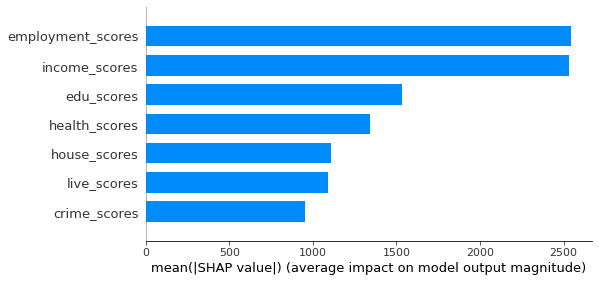

<Figure size 432x288 with 0 Axes>

In [162]:
shap.summary_plot(shap_values, X1, plot_type="bar")
plt.savefig('summary_plot')

The other is to simply draw the shap values of each feature of each sample through scattered points. The relationship between the feature value and its predicted influence can be seen. The distribution of the feature values can be displayed at the same time.

It's interesting that all the domains behave similar. When the feature values are low, they tend to contribute a negative effect to the final IMD score, while they lean to have positive Shapley value when they are large. Additionally, when feature value are low, they are more gathered which means the change of feature value will not obviously influene the Shapley value; when they are high, the distribution of them are more even and it seems that they follows a linear relation: a higher feature value corresponds to a larger Shapley value .


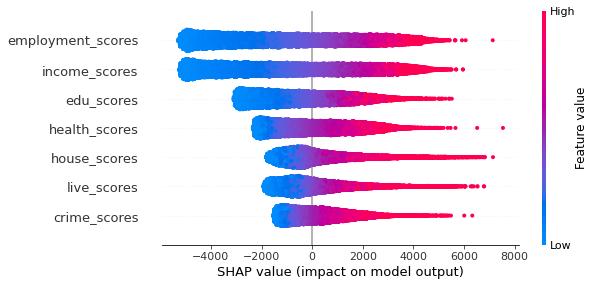

<Figure size 432x288 with 0 Axes>

In [163]:
shap.summary_plot(shap_values, X1)
plt.savefig('summary_plot_scatter')

The following dependence scatter plot gives us a more clear relationship between individual domain scores and their corresponding shapley values. In general, they have the similar tendency: it's super-linear at the begining. Then becomes linear and finally tends to be subliner.
For the first two plots, only the very begining part(just above 0) has super-linearity. Besides, when their score is larger than 0.3, it have the same result as the above figure get which is: a low score corresponds to a negative Shaplely value but a higher score indicates a positive one(for income and employment score,it's when the sore is more than 0.1).
Question: Do we need to describe each figure in detail?

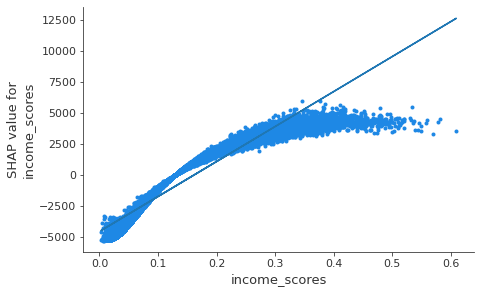

<Figure size 432x288 with 0 Axes>

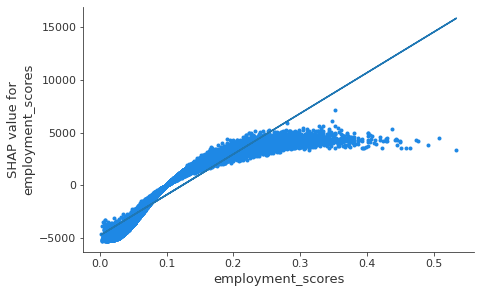

<Figure size 432x288 with 0 Axes>

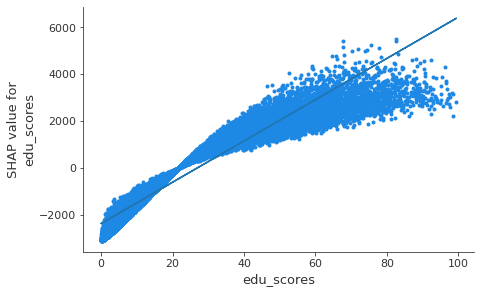

<Figure size 432x288 with 0 Axes>

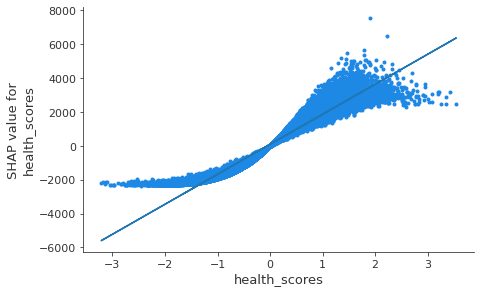

<Figure size 432x288 with 0 Axes>

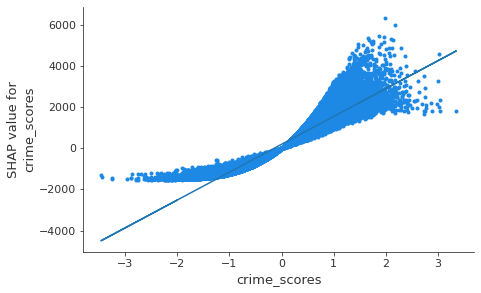

<Figure size 432x288 with 0 Axes>

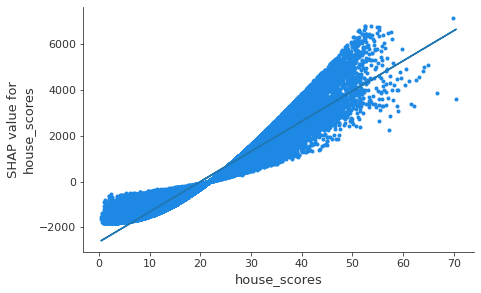

<Figure size 432x288 with 0 Axes>

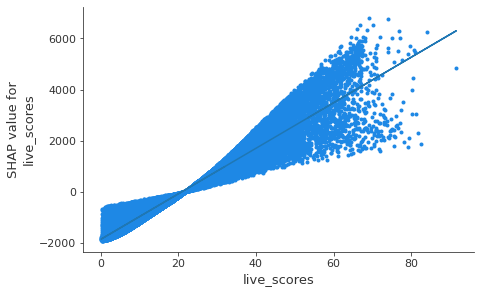

<Figure size 432x288 with 0 Axes>

In [164]:
import matplotlib.pyplot as plt
for i in range(len(X1.columns)):
    x=X1.iloc[:,i].values.reshape(-1, 1)
    y=shap_values[:,i].reshape(-1, 1)
    reg=linear_model.LinearRegression(fit_intercept=True,normalize=False)
    reg.fit(x,y)
    k=reg.coef_
    b=reg.intercept_
    y_pre=k*x+b
    fig, ax = plt.subplots(1,1, figsize=(7,4.5))
    ax.plot(x,y_pre)
    shap.dependence_plot(X1.columns[i], shap_values, X1, interaction_index=None, ax=ax) 
    plt.savefig(f'scatter {X1.columns[i]}')

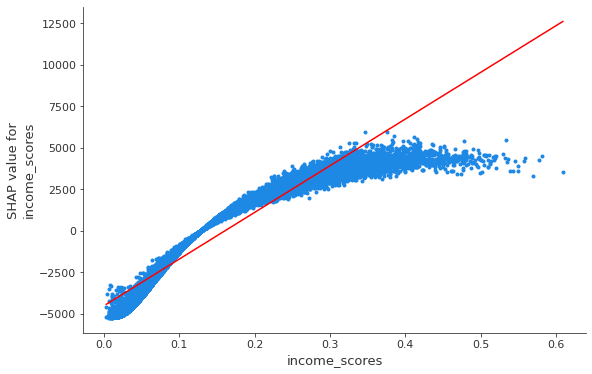

In [165]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.plot(np.unique(X1.income_scores), np.poly1d(np.polyfit(X1.income_scores,shap_values[:,0], 1))(np.unique(X1.income_scores)),color="red")
shap.dependence_plot('income_scores', shap_values, X1, interaction_index=None,ax=ax)
plt.show()

In [166]:
feature_importance = pd.DataFrame()
feature_importance['feature'] = X1.columns
feature_importance['importance'] = np.abs(shap_values).mean(0)
feature_importance.sort_values('importance', ascending=False)

feature   importance
1  employment_scores  2542.109451
0      income_scores  2532.331536
2         edu_scores  1532.545497
3      health_scores  1342.019941
5       house_scores  1110.485765
6        live_scores  1093.446598
4       crime_scores   954.190075

The IMD combines information from the seven domains to produce an overall relative
measure of deprivation. The domains are combined using the following weights:

• Income Deprivation (22.5%)

• Employment Deprivation (22.5%)

• Education, Skills and Training Deprivation (13.5%)

• Health Deprivation and Disability (13.5%)

• Crime (9.3%)

• Barriers to Housing and Services (9.3%)

• Living Environment Deprivation (9.3%)

The weight for each domain calculated from the importance are as follows. Although there are some differences between the weight mentioned above and the calculated one (for the weight derived from importance, the first three domains are slightly higher and the remaining four are lower than the official one), the overall structure are similar.

In [167]:
feature_sum = feature_importance.importance.sum()
for i in feature_importance.feature:
    print(f"The weight of {i}: {feature_importance[feature_importance.feature==i].importance.values/feature_sum}")

The weight of income_scores: [0.22799155]
The weight of employment_scores: [0.22887188]
The weight of edu_scores: [0.13797855]
The weight of health_scores: [0.1208251]
The weight of crime_scores: [0.0859079]
The weight of house_scores: [0.09997955]
The weight of live_scores: [0.09844548]


In [168]:
feature_importance[feature_importance.feature=='income_scores'].importance


0    2532.331536
Name: importance, dtype: float64

In [183]:
lsoa_boundry = gp.read_file(r"C:\Users\a\Documents\casa\FYPPPP\CASA_Dissertation_XiaohanFeng\Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales\Lower_Layer_Super_Output_Areas_December_2011_Generalised_Clipped__Boundaries_in_England_and_Wales.shp")#读取


In [ ]:
lsoa_boundry

In [170]:
# cluster=pd.read_csv("cluster.csv")
# score_cluster=pd.read_csv("score_cluster.csv")

In [172]:
london=pd.read_csv("C:/Users/a/Documents/casa/FYPPPP/CASA_Dissertation_XiaohanFeng/london_lsoa.csv")
london

lad11nm     lsoa11
0     City of London  E01000001
1     City of London  E01000002
2     City of London  E01000003
3     City of London  E01000005
4     City of London  E01032739
...              ...        ...
4830     Westminster  E01033604
4831     Westminster  E01033605
4832     Westminster  E01033606
4833     Westminster  E01033607
4834     Westminster  E01033608

[4835 rows x 2 columns]

In [173]:
# def cluster_plt(clusterdf, column_name):
#     lsoa_cluster = lsoa_boundry.join(clusterdf.set_index("Unnamed: 0"), on="lsoa11cd", how='right')
#     lsoa_cluster=lsoa_cluster.join(london.set_index("lsoa11"), on="lsoa11cd", how='left')
#     lsoa_cluster.to_crs("epsg:27700")
#     fig, ax = plt.subplots(1,1, figsize=(14,18))
#     lsoa_cluster.plot(edgecolor=None, column=column_name,linewidth=0.5, cmap='tab10', 
#              legend=True, ax=ax)
#     ax1 = fig.add_axes([0.11, 0.353, 0.29, 0.29])
#     lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(edgecolor=None, column=column_name, cmap='tab10', ax=ax1)
#     lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(facecolor='none', edgecolor='r',linewidth=0.05, ax=ax)
#     # plt.colorbar(fraction=0.05, pad=0.05)
#     ax.axis('off')
#     ax1.axis('off')

In [ ]:
# lsoa_cluster[lsoa_cluster.lad11nm.notna()]

The distribution seems that rural and urban area are mixed. but the clustering result tend to like the surounding area

In [175]:
import matplotlib as mpl

In [ ]:
# cmap = plt.cm.Set3  # define the colormap
# # extract all colors from the .jet map
# cmaplist = [cmap(i) for i in range(1,4)]
# # force the first color entry to be grey
# # cmaplist[0] = (.5, .5, .5, 1.0)

# # create the new map
# cmap = mpl.colors.LinearSegmentedColormap.from_list(
#     'Custom cmap', cmaplist, 3)

# bounds = np.linspace(0, 3, 4)
# norm = mpl.colors.BoundaryNorm(bounds, 3)

# fig, ax = plt.subplots(1,1, figsize=(14,18))
# lsoa_cluster.plot(edgecolor=None, column='cluster',
#                   linewidth=0.5, cmap=cmap, norm=norm,legend=True, ax=ax)
# # ax1 = fig.add_axes([0.11, 0.353, 0.29, 0.29])
# lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(edgecolor=None, 
#         column='Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)', cmap='Paired', ax=ax1)
# lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(facecolor='none', edgecolor='b',linewidth=0.05, ax=ax)



# ax.axis('off')
# ax1.axis('off')


In [ ]:
# fig, ax = plt.subplots(1,1, figsize=(14,18))
# lsoa_cluster.plot(edgecolor=None, column='cluster',linewidth=0.5, legend=True, ax=ax)

In [17]:
shap_for_cluster=pd.concat([shap_csv,IndicesPd['LSOA code (2011)']],axis=1)
shap_for_cluster.set_index("LSOA code (2011)",drop=True, inplace = True)
shap_for_cluster.columns = ['income_scores', 'employment_scores', 'edu_scores', 'health_scores',
       'crime_scores', 'house_scores', 'live_scores']
shap_for_cluster

income_scores  employment_scores   edu_scores  \
LSOA code (2011)                                                  
E01000001          -5196.766667       -5217.316667 -3078.733333   
E01000002          -4731.540476       -5002.190476 -3085.673810   
E01000003          -1606.107143        -774.340476 -1856.790476   
E01000005           2440.878571        1579.545238    61.795238   
E01000006           -421.023810       -2257.657143  -799.623810   
...                         ...                ...          ...   
E01033764           4274.535714        4100.802381  2260.469048   
E01033765           4085.321429        4252.838095  1985.938095   
E01033766          -1017.359524       -1412.292857 -1167.976190   
E01033767           4132.547619        3967.580952  2046.814286   
E01033768           2679.535714        3401.552381  -181.914286   

                  health_scores  crime_scores  house_scores  live_scores  
LSOA code (2011)                                                          
E01000001          -2242.483333  -1498.250000   1473.233333  1255.316667  
E01000002          -1997.573810  -1505.807143    489.842857   152.942857  
E01000003           -249.790476  -1010.907143   3183.376190  2096.559524  
E01000005           -228.238095   -878.004762   2478.411905   564.611905  
E01000006           -756.207143   -216.590476   4167.742857   495.359524  
...                         ...           ...           ...          ...  
E01033764           2888.019048   1320.869048   -220.847619   -42.847619  
E01033765           2712.738095   1186.554762   -136.595238  -333.795238  
E01033766           2441.040476     88.390476  -1303.292857  4227.490476  
E01033767           2671.780952    254.547619   -433.319048  1635.047619  
E01033768           3230.235714   2010.169048    -70.680952  1796.102381  

[32844 rows x 7 columns]

In [12]:
score_for_cluster=pd.concat([X1,IndicesPd['LSOA code (2011)']],axis=1)
score_for_cluster.set_index("LSOA code (2011)",drop=True, inplace = True)


In [178]:
# use SSE to select k
def sse_k(df,name):
    SSE = []  # Store the SSE of each result
    for k in range(1, 9):
        estimator = KMeans(n_clusters=k)  # Construct a cluster
        estimator.fit(df)
        SSE.append(estimator.inertia_)
    X = range(1, 9)
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.plot(X, SSE, 'o-')
    plt.show()
    plt.savefig('sse {name}')

In [179]:
# use silhouette coefficient score to select k
def silhouette_k(df,name):  
    Scores = []  # Store the silhouette coefficient scores
    for k in range(2, 9):
        estimator = KMeans(n_clusters=k)   #Construct a cluster
        estimator.fit(df)
        Scores.append(silhouette_score(df, estimator.labels_, metric='euclidean'))
    X = range(2, 9)
    plt.xlabel('k')
    plt.ylabel('silhouette_score')
    plt.plot(X, Scores, 'o-')
    plt.show()
    plt.savefig('silhoue {name}')

#  Can these two have different numbers of clusters

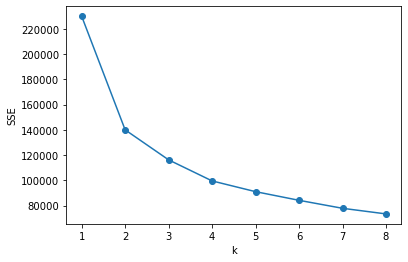

<Figure size 432x288 with 0 Axes>

In [180]:

sse_k(sklearn.preprocessing.scale(score_for_cluster), "score")

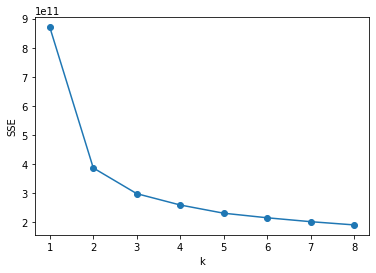

<Figure size 432x288 with 0 Axes>

In [181]:
sse_k(shap_for_cluster,"shap")

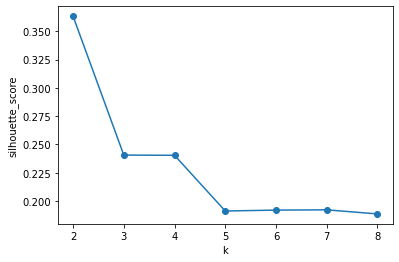

<Figure size 432x288 with 0 Axes>

In [184]:
silhouette_k(sklearn.preprocessing.scale(score_for_cluster),"score")

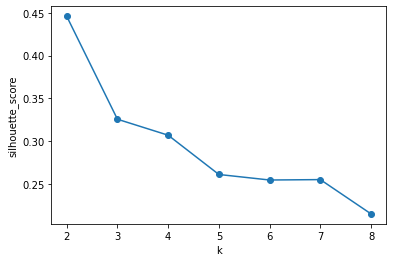

<Figure size 432x288 with 0 Axes>

In [185]:
silhouette_k(shap_for_cluster,"shap")

In [18]:
cluster_result_shap3=KMeans(n_clusters=3).fit(shap_for_cluster)
cluster_result_score3=KMeans(n_clusters=3).fit(sklearn.preprocessing.scale(score_for_cluster))

In [19]:
cluster_result_shap4=KMeans(n_clusters=4).fit(shap_for_cluster)
cluster_result_score4=KMeans(n_clusters=4).fit(sklearn.preprocessing.scale(score_for_cluster))

In [188]:
import matplotlib as mpl
# flatui = ["#9b59b6", "#3498db", "#95a5a6"]
# palette=sns.color_palette(flatui)
def cluster_plt(clusterdf, column_name, n,figname):
    cmap = plt.cm.Set3  # define the colormap
    cmaplist = [cmap(i) for i in range(1,n+1)]# extract n colors from the .jet map
    # what cmaplist[0] likes: = (.5, .5, .5, 1.0)

    # create the new map
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, n)

    bounds = np.linspace(0, n, n+1)#the boundary of the color bar is 0 to n
    norm = mpl.colors.BoundaryNorm(bounds, n) #apply the above bound to the color bar
    visualise=pd.concat([pd.DataFrame({"cluster":clusterdf.labels_,
                                        "imd_decile":IndicesPd['Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)']
                                      }),IndicesPd['LSOA code (2011)']],axis=1)
    visualise.set_index("LSOA code (2011)",drop=True, inplace = True)
    lsoa_cluster = lsoa_boundry.join(visualise, on="lsoa11cd", how='right')
    
    lsoa_cluster=lsoa_cluster.join(london.set_index("lsoa11"), on="lsoa11cd", how='left')
    lsoa_cluster.to_crs("epsg:27700")
    fig, ax = plt.subplots(1,1, figsize=(14,18))
    lsoa_cluster.plot(edgecolor=None, column=column_name,linewidth=0.5, cmap=cmap, norm=norm,
             legend=True, ax=ax)
    ax1 = fig.add_axes([0.11, 0.353, 0.29, 0.29])
    lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(edgecolor=None, column=column_name, cmap=cmap,norm=norm, ax=ax1)
    lsoa_cluster[lsoa_cluster.lad11nm.notna()].plot(facecolor='none', edgecolor='b',linewidth=0.05,norm=norm, ax=ax)
    # plt.colorbar(fraction=0.05, pad=0.05)
    ax.axis('off')
    ax1.axis('off')
    plt.savefig(f'map {figname}{n}')

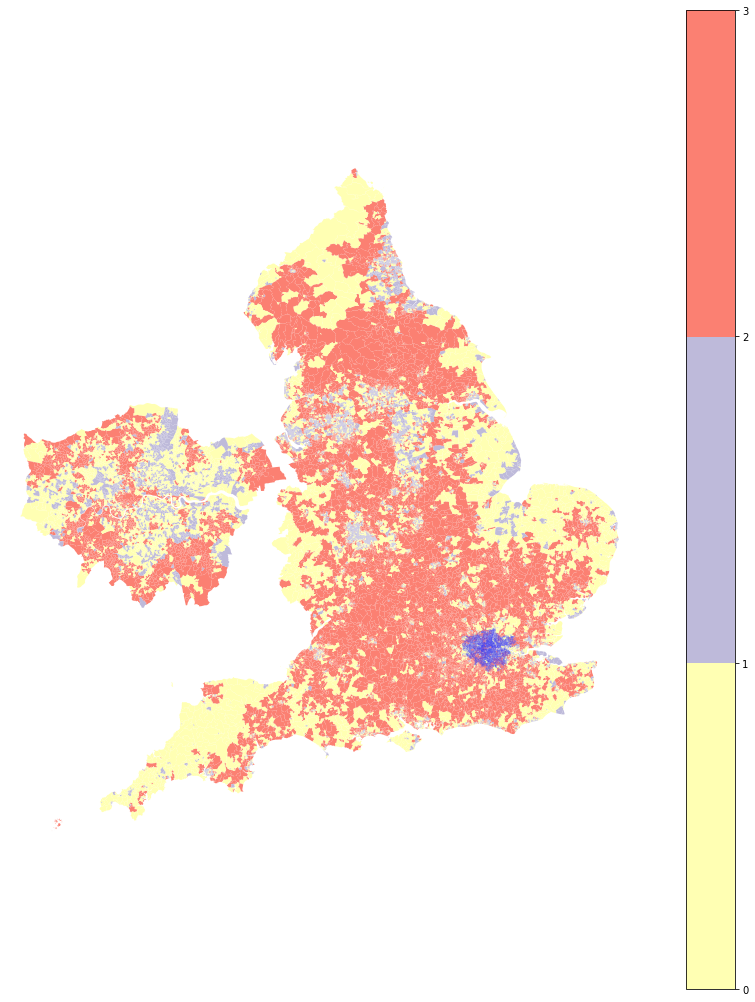

In [189]:
cluster_plt(cluster_result_shap3, "cluster", 3,'shap')

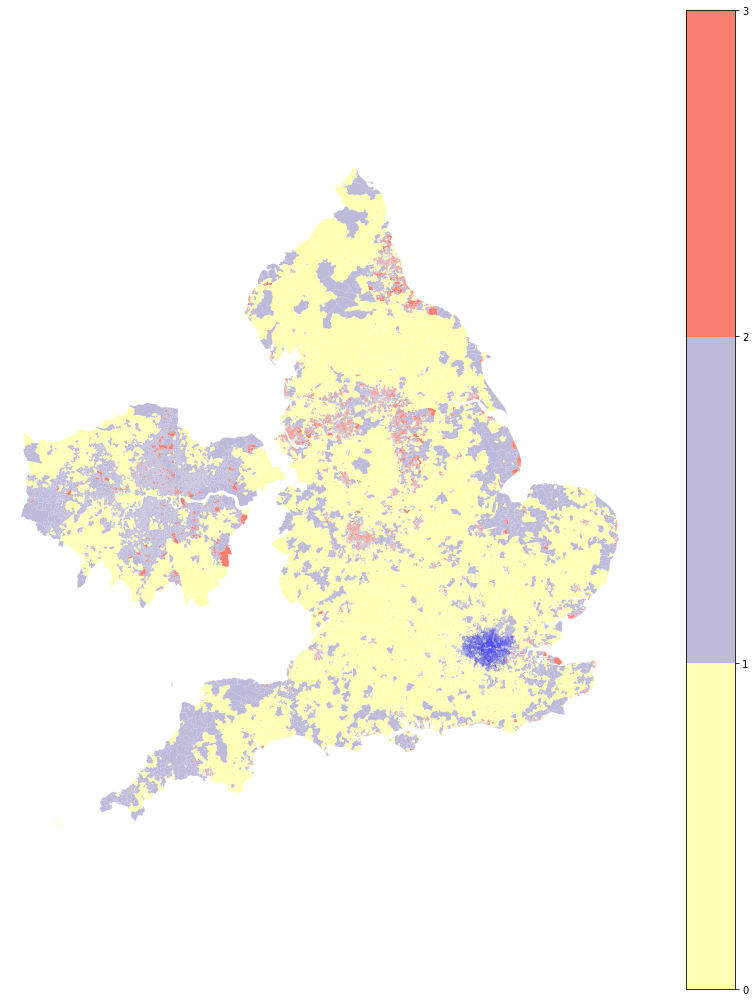

In [190]:
cluster_plt(cluster_result_score3, "cluster",3,'score')

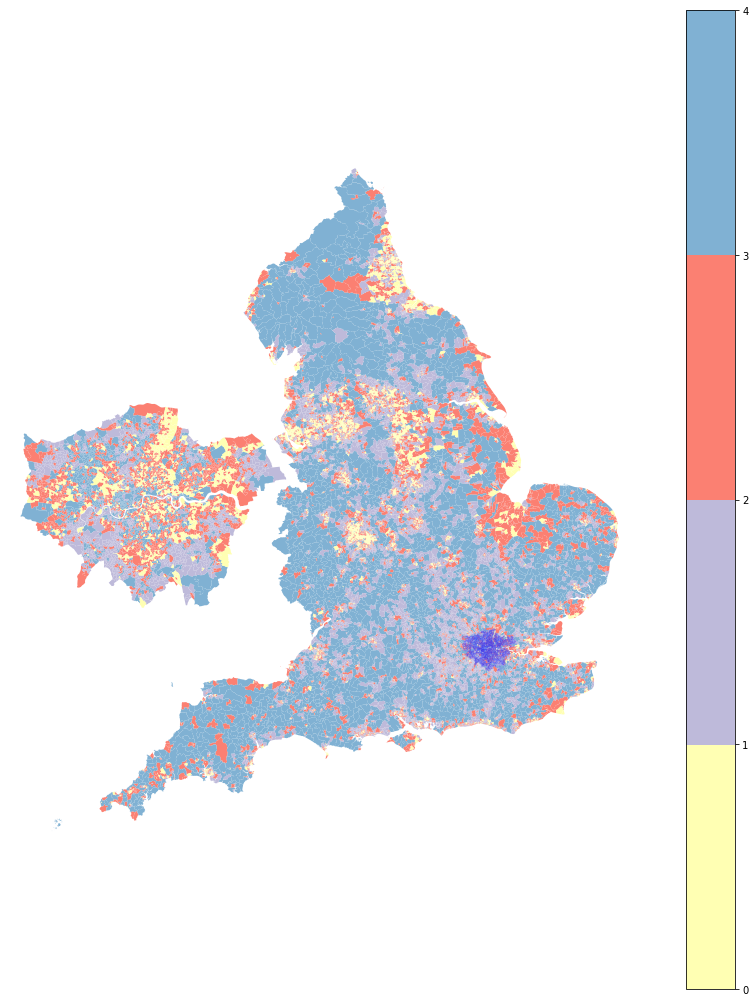

In [191]:
cluster_plt(cluster_result_shap4, "cluster",4,'shap')

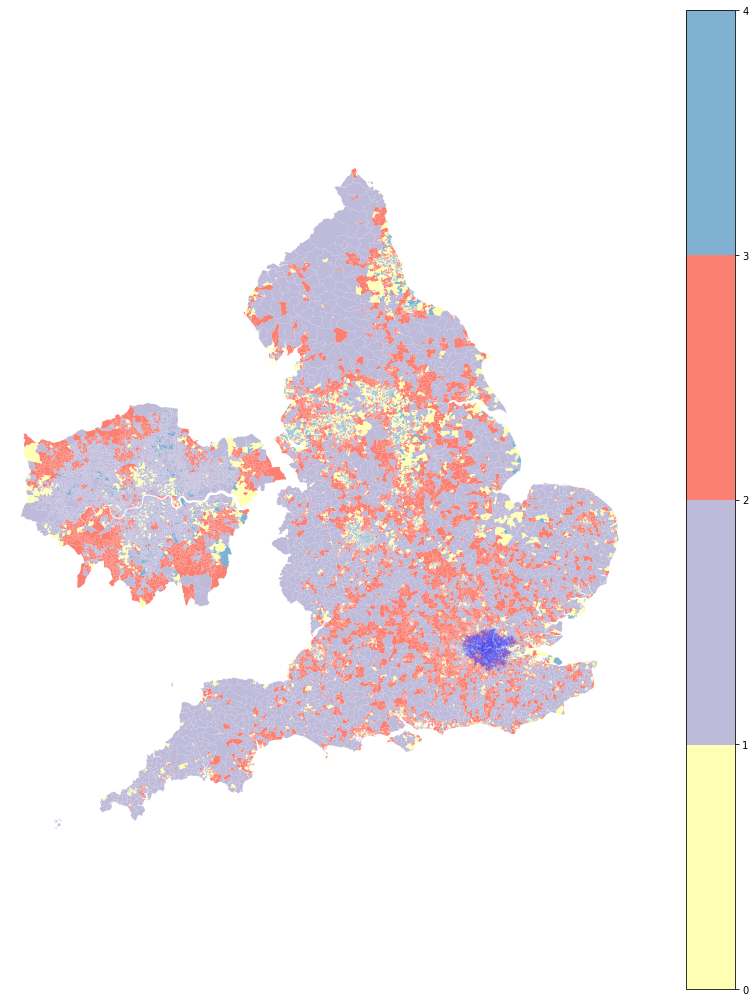

In [192]:
cluster_plt(cluster_result_score4, "cluster",4,"score")

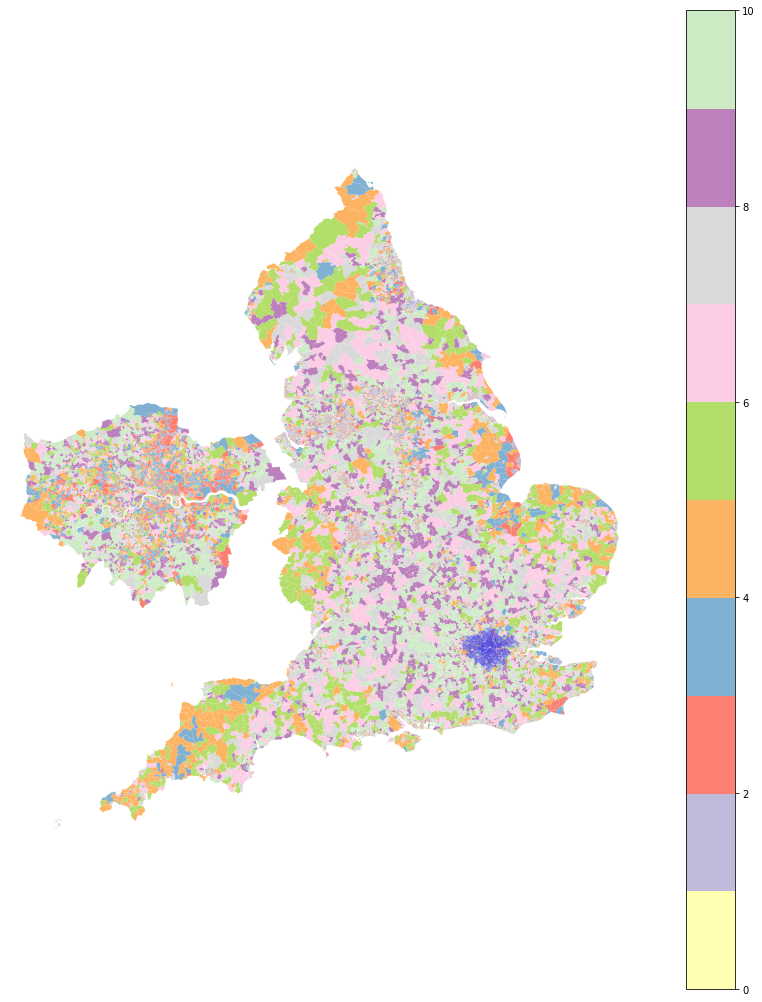

In [193]:
cluster_plt(cluster_result_score4, "imd_decile",10,'imd_decile')

In [194]:
from sklearn import metrics
ARI3 = metrics.adjusted_rand_score(cluster_result_score3.labels_ ,cluster_result_shap3.labels_)
ARI4 = metrics.adjusted_rand_score(cluster_result_score4.labels_ ,cluster_result_shap4.labels_)
print(ARI3)
print(ARI4)

0.48145317823068523
0.4843173578942444


In [37]:
def center(df):
    centerdf=df.cluster_centers_
    min_max_scale=sklearn.preprocessing.MinMaxScaler() # 创建MinMaxScaler对象
    data=min_max_scale.fit_transform(centerdf)
    return data
shap4cluster=center(cluster_result_shap4)    
shap3cluster=center(cluster_result_shap3) 
score4cluster=center(cluster_result_score4)
score3cluster=center(cluster_result_score3)
# sklearn.preprocessing.MinMaxScaler.fit_transform(jj)
print("cluster_result_score3")
print(cluster_result_score3.cluster_centers_)
print("cluster_result_shap3")
print(cluster_result_shap3.cluster_centers_)
print("cluster_result_score4")
print(cluster_result_score4.cluster_centers_)
print("cluster_result_shap4")
print(cluster_result_shap4.cluster_centers_)

cluster_result_score3
[[ 0.12022244  0.06738481  0.03405208  0.27713509  0.38749025  0.16399879
   0.40160646]
 [-0.75416886 -0.7208341  -0.66100823 -0.76809493 -0.7281364  -0.06997022
  -0.38679814]
 [ 1.69935769  1.72646045  1.64283656  1.39801925  1.05692556 -0.1710805
   0.14039849]]
cluster_result_shap3
[[ 2435.3083131   2467.96248264  1386.36843326  1751.25758462
    987.71484815    89.14424278   208.40311715]
 [ -815.91563498  -883.2890085   -443.20275034   120.36908463
    340.53407615   391.85054029   490.60065961]
 [-3835.09358544 -3827.13986944 -2025.08145932 -1331.19625
   -599.60959773   174.0827669   -436.34093748]]
cluster_result_score4
[[-0.77328012 -0.72662624 -0.66728959 -0.74935199 -0.73772769 -0.29748387
  -0.59587843]
 [ 1.83057931  1.83519467  1.72253353  1.45025497  1.1284821  -0.07310902
   0.21493309]
 [-0.20984283 -0.36763799 -0.45506912 -0.3830462   0.02089158  1.26431083
   0.92591976]
 [ 0.19623809  0.24090087  0.28347314  0.49624017  0.37358143 -0.44269115

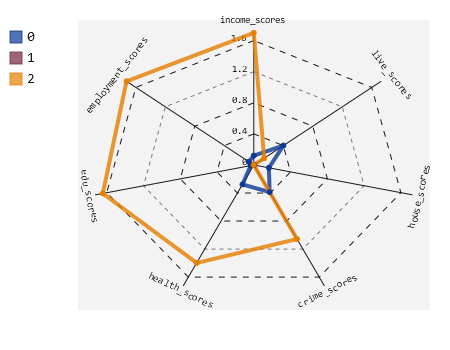

In [32]:
#example of using original clustering center(not using minmax transformation)
import pygal
from pygal.style import CleanStyle
#准备数据


#准备标签

labels = ['0','1','2']

#创建pygal.Radar对象(雷达图)

radar = pygal.Radar(stroke_style={'width': 4,  'linejoin': 'round'},style=CleanStyle,width=450, height=350,dot_size=5)
radar.x_labels=shap_for_cluster.columns 

#采用循环为雷达图添加数据

for i,per in enumerate(labels):

    radar.add(labels[i],cluster_result_score3.cluster_centers_[i])

radar




In [24]:
def radar_plot(labels, cluster_centers, who):
    

    #创建pygal.Radar对象(雷达图)

    radar = pygal.Radar(stroke_style={'width': 3.5,  'linejoin': 'round'},style=CleanStyle,width=500, height=400,dots_size=4)
    radar.x_labels=shap_for_cluster.columns 
    for i,per in enumerate(labels):
        radar.add(labels[i],cluster_centers[i])
    # radar.title="radar plot for 4 clusters in shap"
    # radar.dot_size=28
    radar.render_to_file(f"radar plot for {len(labels)} clusters in {who}.svg")
    return radar

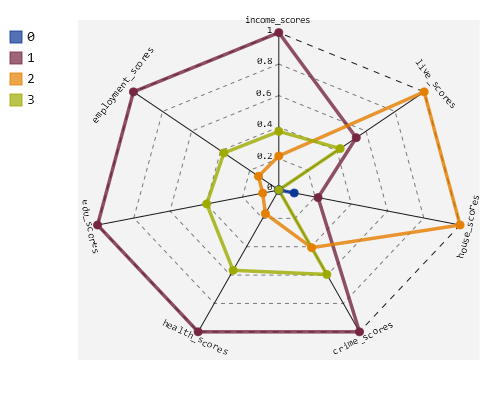

In [25]:
radar_plot( ['0','1','2','3'],score4cluster,'score')

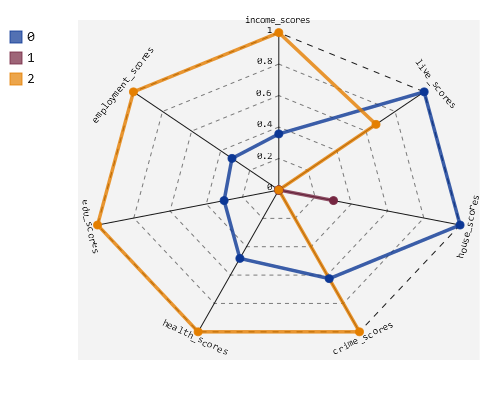

In [26]:
radar_plot( ['0','1','2'],score3cluster,'score')

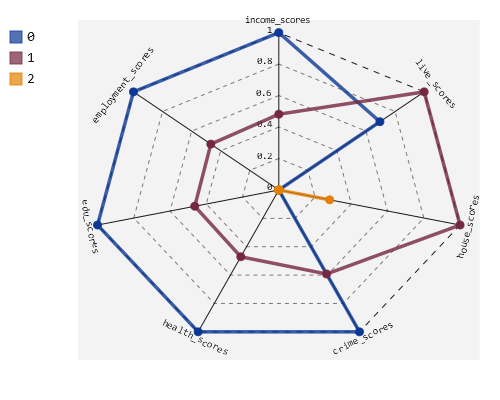

In [27]:
radar_plot( ['0','1','2'],shap3cluster,'shap')

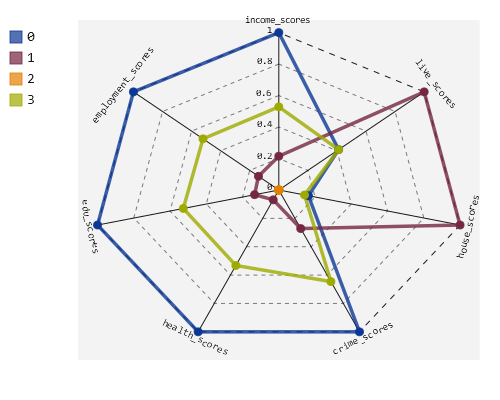

In [28]:
radar_plot( ['0','1','2','3'],shap4cluster,'shap')